In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.rcParams.update({ 'font.size': 14 })

In [64]:
df = pd.read_csv('./basic_cnn_results.csv')
datasets = sorted(df.Train.unique())

In [5]:
def label_for(ds):
  if 'single' in ds:
    s = f"80,000 steps * 1 run\n(restart {1+int('2' in ds)})"
  else:
    s = '80 steps * 1000 runs\n(sample '
    if 'uniform' in ds:
      s += 'every 1K)'
    else:
      s += 'irregularly)'
  return s

Text(0.5,1,'Basic CNN results on four $\\mathtt{pyqg}$ datasets\n(predicting $S_q$ from $q$, 64 to 32 res.)')

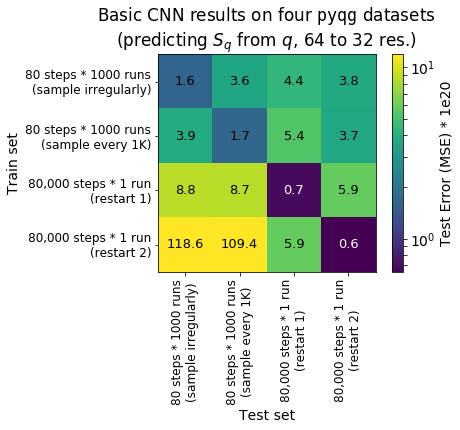

In [88]:
grid = np.array([[
  df[(df.Train==d1)&(df.Test==d2)].MSE.values[0]
    for d2 in datasets]
    for d1 in datasets]) * 1e20

plt.imshow(grid, norm=colors.LogNorm(vmin=grid.min(), vmax=grid.max()/10))
for i, row in enumerate(grid):
  for j, val in enumerate(row):
    plt.text(j,i,f"{val:.1f}",ha='center',va='center',fontsize=13,color=('white' if val<1 else 'black'))
labels = list(map(label_for, datasets))
plt.xticks(range(len(datasets)), labels, rotation=90, fontsize=12)
plt.yticks(range(len(datasets)), labels, fontsize=12)
plt.ylabel("Train set")
plt.xlabel("Test set")
plt.colorbar(label='Test Error (MSE) * 1e20')
plt.title("Basic CNN results on four $\mathtt{pyqg}$ datasets\n(predicting $S_q$ from $q$, 64 to 32 res.)")

In [2]:
import sys; sys.path.append('..')
from pyqg_subgrid_dataset import PYQGSubgridDataset
from models import *

In [8]:
import os

pyqg_dir = '/scratch/zanna/data/pyqg'

def load_model(path):
    shape = (1, 32, 32)
    net = BasicCNN(shape, shape)
    net.load(path+'/basic_cnn')
    return net

datasets = [
    PYQGSubgridDataset(os.path.join(pyqg_dir, ds))
    for ds in os.listdir(pyqg_dir)
]

models = [
    load_model(os.path.join(pyqg_dir, ds))
    for ds in os.listdir(pyqg_dir)
]

/ext3/miniconda3/envs/m2lines/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [25]:
dirs = os.listdir(pyqg_dir)
dirs

['many_runs_few_steps_uniform',
 'single_run_all_steps2',
 'many_runs_few_steps_irregular',
 'single_run_all_steps']

In [29]:
from collections import defaultdict
times = {}
errors = defaultdict(dict)

for ds in datasets:
    print(ds.name)
    x = ds.to_np(ds.dataset.coarse_data.potential_vorticity)
    y = ds.to_np(ds.dataset.forcing_data.potential_vorticity)
    order = np.arange(len(x))
    ds.random_state.shuffle(order)
    split_at = int(len(x)*0.25)
    train = order[split_at:]
    test = order[:split_at]
    x = x[test]
    y = y[test]
    
    times[ds.name] = ds.dataset.time_idxs[test]
    
    for model, mdir in zip(models, dirs):
        print('  ' + mdir)
        errs = []
        for xb, yb in minibatch(x, y, as_tensor=False):
            errs.append(np.sum((yb-model.predict(xb))**2, axis=1))        
        errors[ds.name][mdir] = np.hstack(errs)

many_runs_few_steps_uniform
  many_runs_few_steps_uniform
  single_run_all_steps2
  many_runs_few_steps_irregular
  single_run_all_steps
single_run_all_steps2
  many_runs_few_steps_uniform
  single_run_all_steps2
  many_runs_few_steps_irregular
  single_run_all_steps
many_runs_few_steps_irregular
  many_runs_few_steps_uniform
  single_run_all_steps2
  many_runs_few_steps_irregular
  single_run_all_steps
single_run_all_steps
  many_runs_few_steps_uniform
  single_run_all_steps2
  many_runs_few_steps_irregular
  single_run_all_steps


In [89]:
times['many_runs_few_steps_uniform']

array([38000, 27000, 25000, ..., 33000, 23000, 42000])

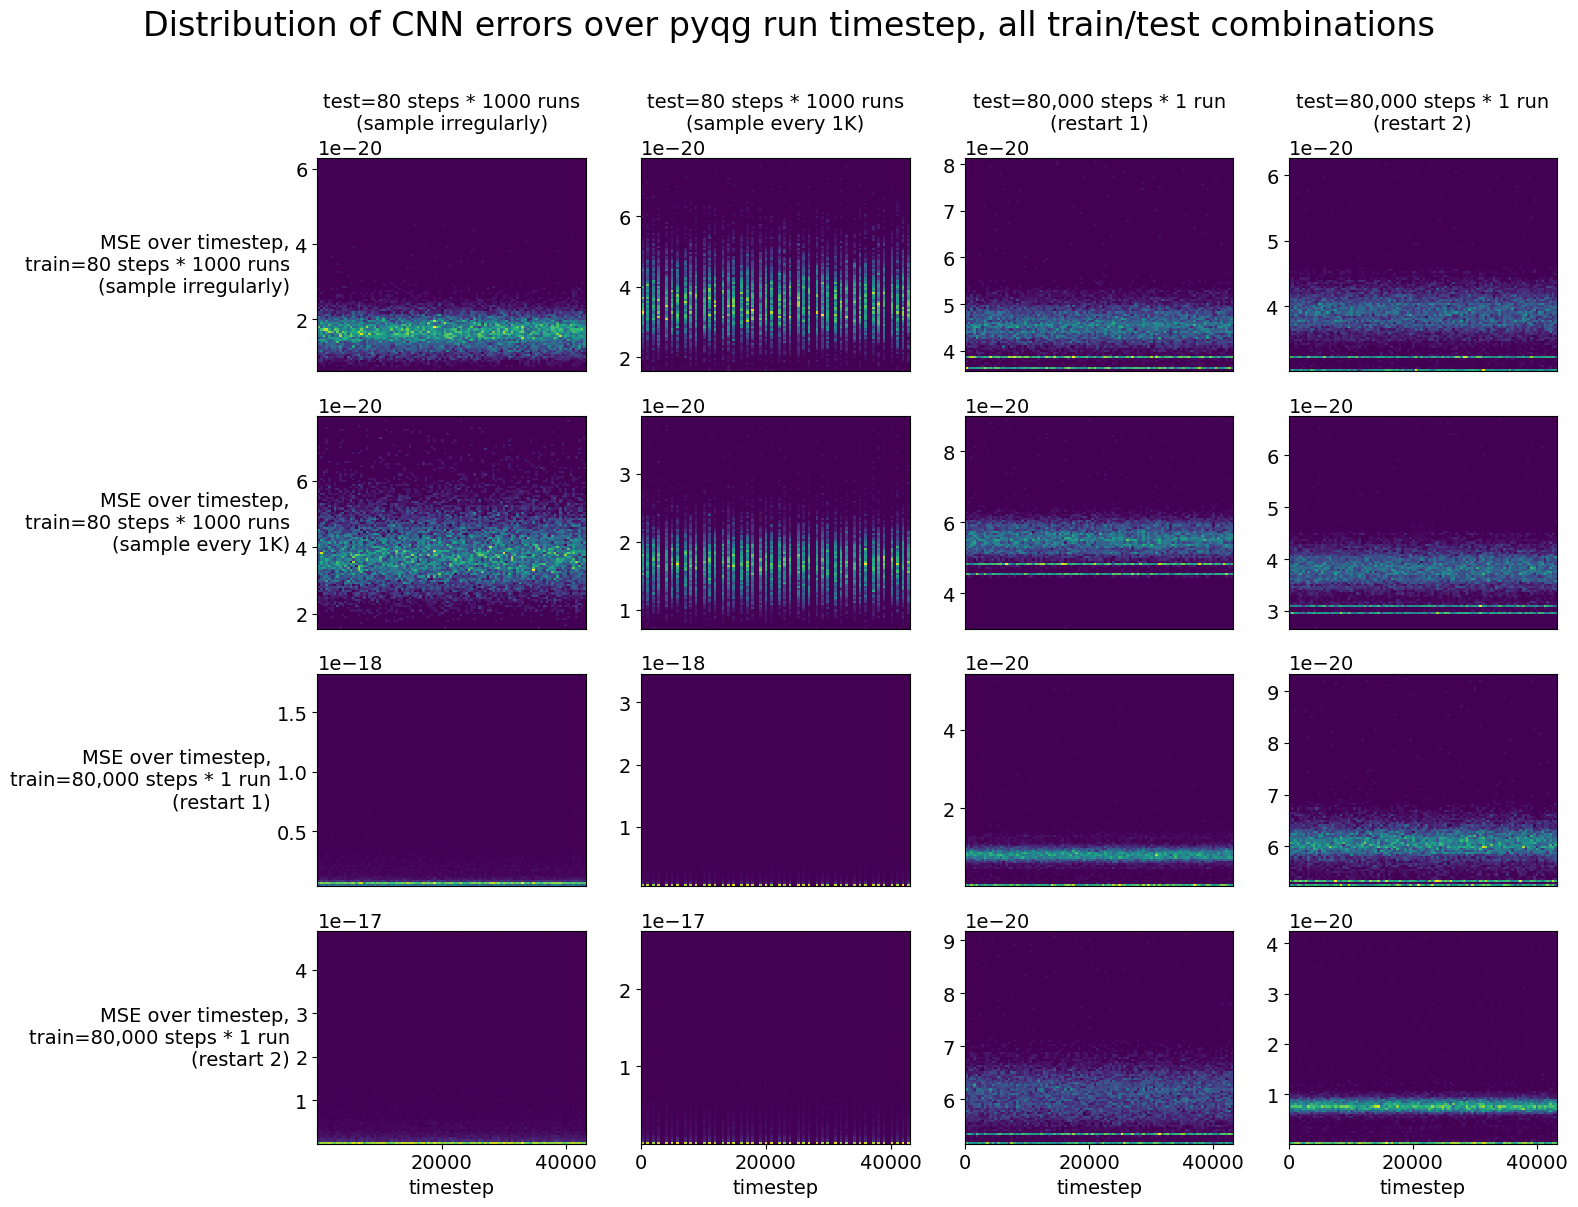

In [91]:
with figure_grid(4,4,rowwidth=16) as g:
    g.title("Distribution of CNN errors over pyqg run timestep, all train/test combinations", fontsize=24, y=0.98)
    for i, m2 in enumerate(sorted(dirs)):
        for j, m1 in enumerate(sorted(dirs)):
            g.next()
            if j == 0:
                plt.ylabel(f'MSE over timestep,\ntrain={label_for(m2)}', rotation=0, ha='right', va='center')
            if i == 0:
                plt.title(f'test={label_for(m1)}',y=1.1, fontsize=14)
            plt.hist2d(times[m1], errors[m1][m2], bins=100)
            #
            if i == 3:
                plt.xlabel('timestep')
            else:
                plt.xticks([])

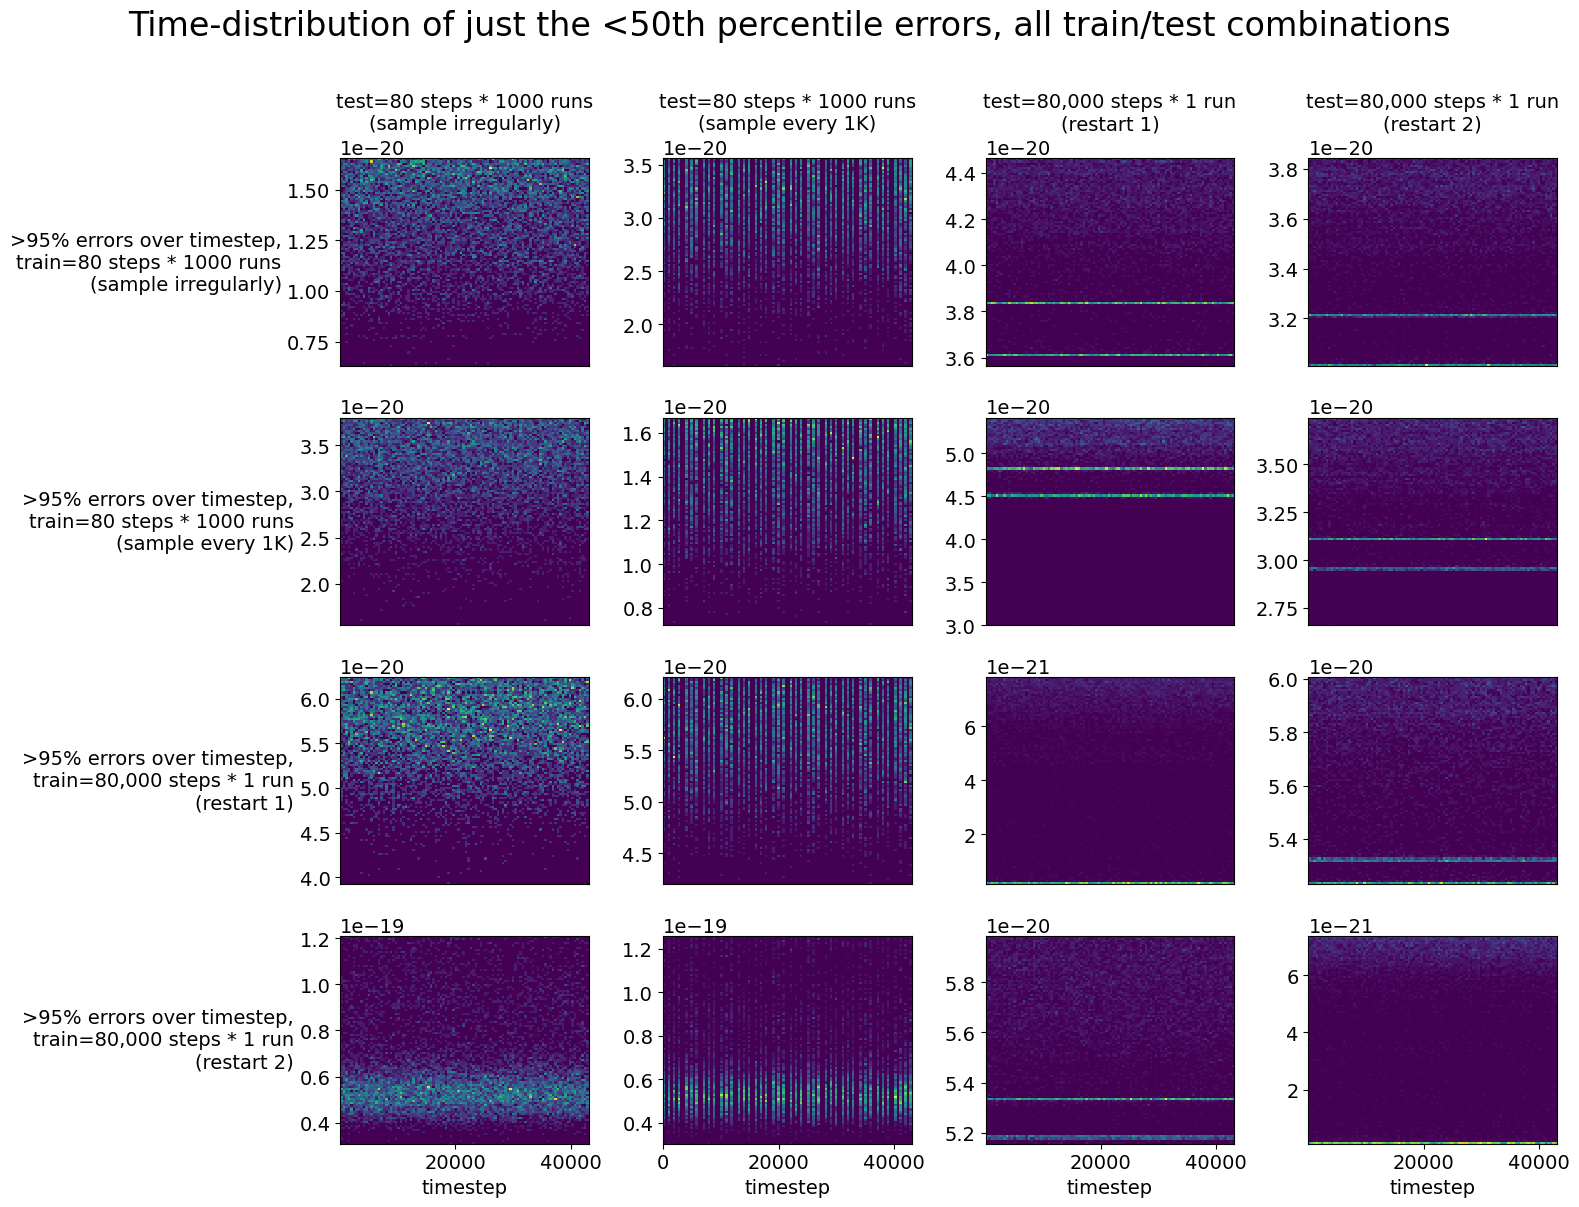

In [92]:
with figure_grid(4,4,rowwidth=16) as g:
    g.title("Time-distribution of just the <50th percentile errors, all train/test combinations", fontsize=24, y=0.98)
    for i, m2 in enumerate(sorted(dirs)):
        for j, m1 in enumerate(sorted(dirs)):
            g.next()
            if j == 0:
                plt.ylabel(f'>95% errors over timestep,\ntrain={label_for(m2)}', rotation=0, ha='right', va='center')
            if i == 0:
                plt.title(f'test={label_for(m1)}',y=1.1, fontsize=14)
                
            pct = np.percentile(errors[m1][m2], 50)
            idx = np.argwhere(errors[m1][m2] < pct)[:,0]
            
            plt.hist2d(times[m1][idx], errors[m1][m2][idx], bins=100)
            #
            if i == 3:
                plt.xlabel('timestep')
            else:
                plt.xticks([])

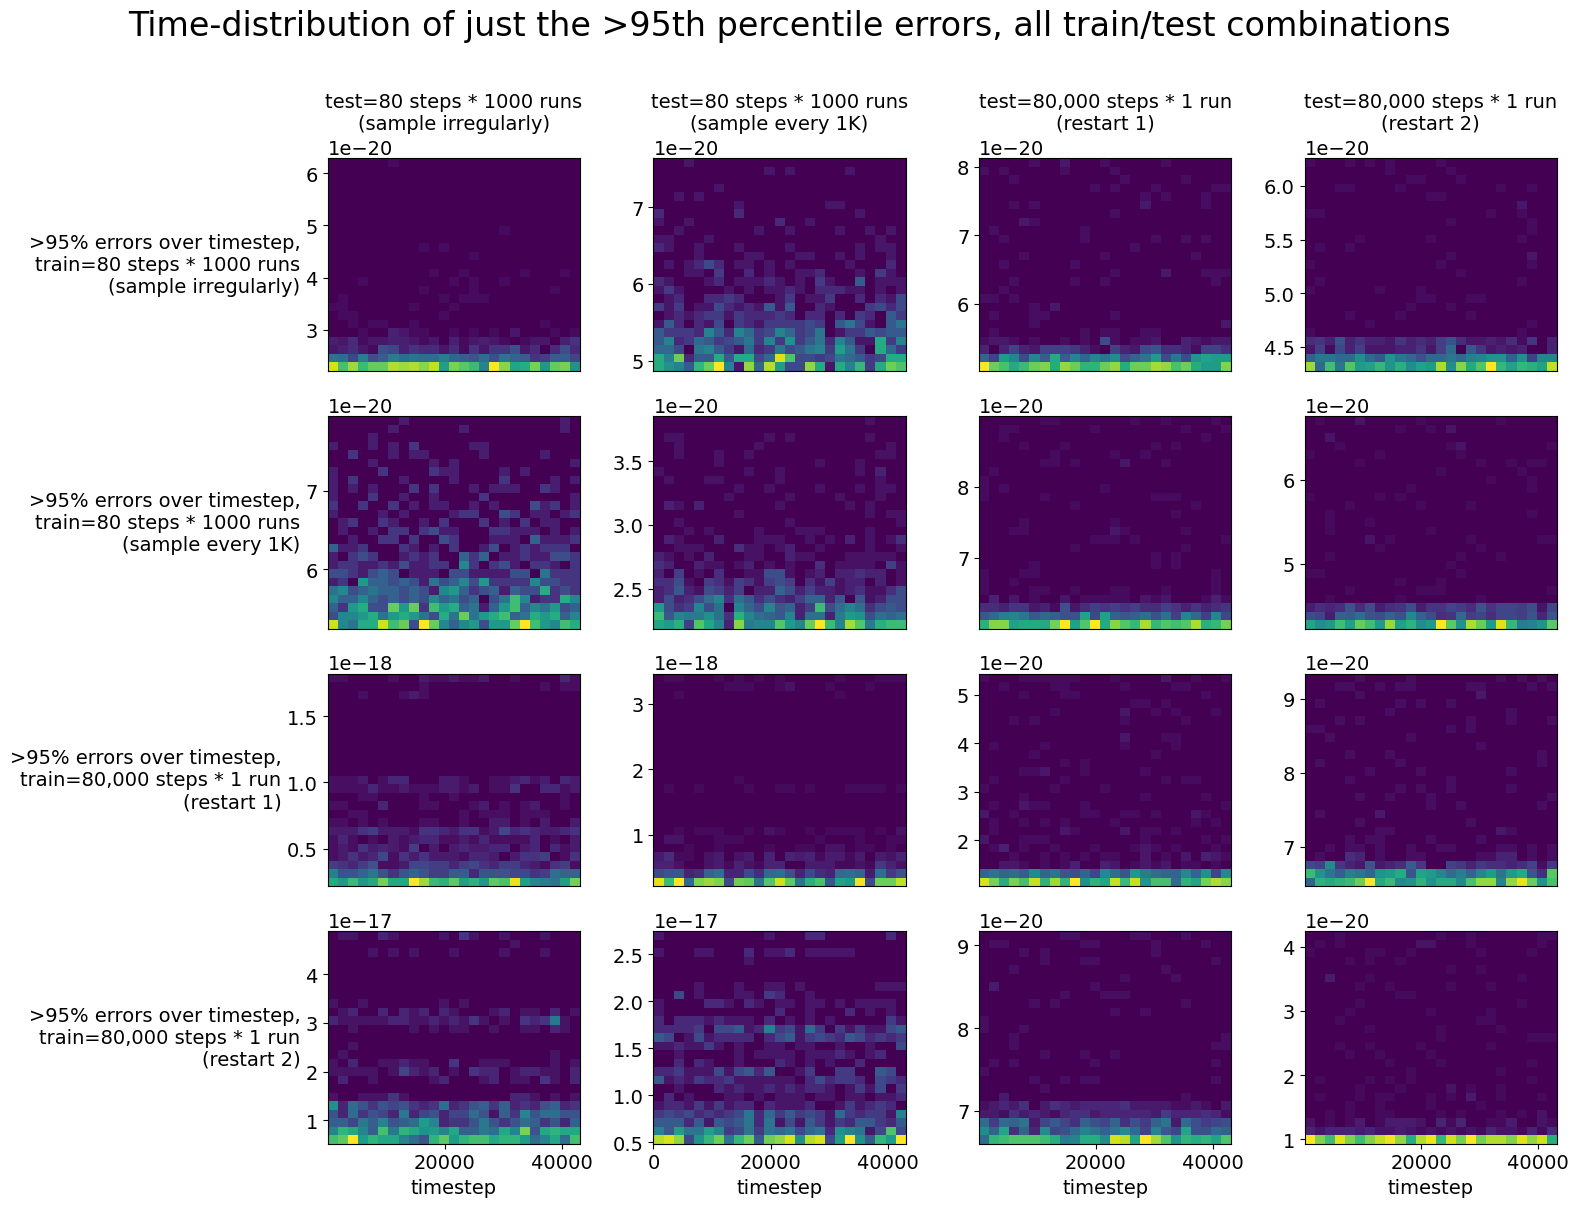

In [95]:
with figure_grid(4,4,rowwidth=16) as g:
    g.title("Time-distribution of just the >95th percentile errors, all train/test combinations", fontsize=24, y=0.98)
    for i, m2 in enumerate(sorted(dirs)):
        for j, m1 in enumerate(sorted(dirs)):
            g.next()
            if j == 0:
                plt.ylabel(f'>95% errors over timestep,\ntrain={label_for(m2)}', rotation=0, ha='right', va='center')
            if i == 0:
                plt.title(f'test={label_for(m1)}',y=1.1, fontsize=14)
                
            pct = np.percentile(errors[m1][m2], 95)
            idx = np.argwhere(errors[m1][m2] > pct)[:,0]
            
            plt.hist2d(times[m1][idx], errors[m1][m2][idx], bins=25)
            #
            if i == 3:
                plt.xlabel('timestep')
            else:
                plt.xticks([])

In [63]:
errors['many_runs_few_steps_uniform']['single_run_all_steps2'].mean()

1.093301e-18

In [61]:
np.median(errors['many_runs_few_steps_uniform']['single_run_all_steps2'])

1.2580551e-19

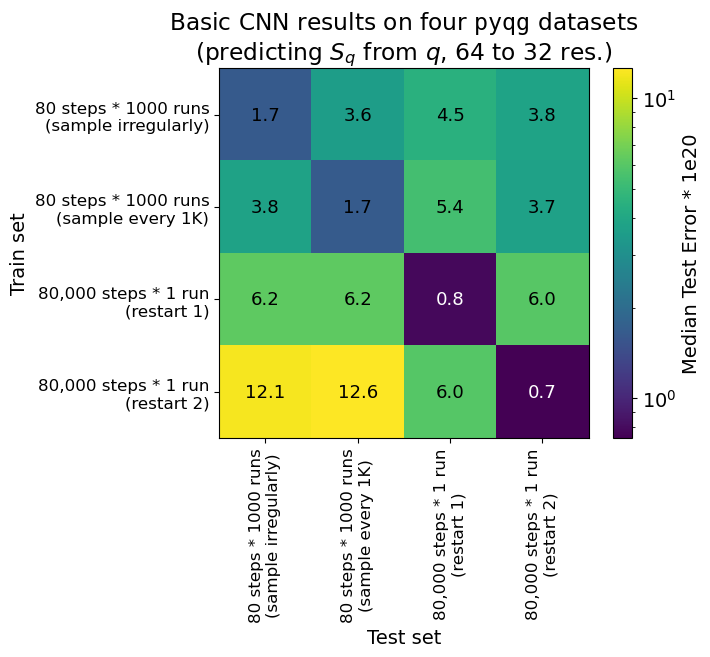

In [71]:
for percentile in [5,10,25,33,50,67]

grid = np.array([[
  np.median(errors[d2][d1])
    for d2 in datasets]
    for d1 in datasets]) * 1e20

plt.imshow(grid, norm=colors.LogNorm(vmin=grid.min(), vmax=grid.max()))
for i, row in enumerate(grid):
  for j, val in enumerate(row):
    plt.text(j,i,f"{val:.1f}",ha='center',va='center',fontsize=13,color=('white' if val<1 else 'black'))
labels = list(map(label_for, datasets))
plt.xticks(range(len(datasets)), labels, rotation=90, fontsize=12)
plt.yticks(range(len(datasets)), labels, fontsize=12)
plt.ylabel("Train set")
plt.xlabel("Test set")
plt.colorbar(label='Median Test Error * 1e20')
plt.title("Basic CNN results on four $\mathtt{pyqg}$ datasets\n(predicting $S_q$ from $q$, 64 to 32 res.)")
plt.show()

In [33]:
import matplotlib.pyplot as plt
class figure_grid():
    def next_subplot(self, title=None, **kwargs):
        if self.next_title is not None:
          plt.title(self.next_title)
        self.subplots += 1
        self.next_title = title
        return self.fig.add_subplot(self.rows, self.cols, self.subplots, **kwargs)

    def each_subplot(self):
        for _ in range(self.rows * self.cols):
            yield self.next_subplot()

    def title(self, title, fontsize=16, y=1.0, **kwargs):
        self.fig.suptitle(title, y=y, fontsize=fontsize, va='bottom', **kwargs)

    def __init__(self, rows, cols, rowheight=3, rowwidth=12, after_each=lambda: None, filename=None):
        self.rows = rows
        self.cols = cols
        self.fig = plt.figure(figsize=(rowwidth, rowheight*self.rows))
        self.subplots = 0
        self.next_title = None
        self.filename = filename

    def __enter__(self):
        return self

    def __exit__(self, _type, _value, _traceback):
        if self.next_title is not None:
          plt.title(self.next_title)
        if self.filename:
            try:
                plt.tight_layout()
                plt.savefig(self.filename, bbox_inches='tight')
            except:
                print("ERROR SAVING FIGURE")
            plt.close(self.fig)
        else:
            plt.tight_layout()
            plt.show()

    next = next_subplot